In [4]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import statsmodels.api as sm

from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

from sklearn.preprocessing import OneHotEncoder
import datetime

In [86]:
def return_series(csv_path):
    """
    
    """
    
    def parse(x):
        return datetime.datetime.strptime(x, '%m/%d/%Y %H')
    
    df = pd.read_csv(csv_path, parse_dates=[['Date','Hour']], date_parser=parse)
    
    conditions = [
    df['Plaza ID'].eq(21) | df['Plaza ID'].eq(1),
    df['Plaza ID'].eq(22) | df['Plaza ID'].eq(2),
    df['Plaza ID'].eq(23) | df['Plaza ID'].eq(3),
    df['Plaza ID'].eq(24) | df['Plaza ID'].eq(4),
    df['Plaza ID'].eq(25) | df['Plaza ID'].eq(5),
    df['Plaza ID'].eq(26) | df['Plaza ID'].eq(6),
    df['Plaza ID'].eq(27) | df['Plaza ID'].eq(7),
    df['Plaza ID'].eq(28) | df['Plaza ID'].eq(8),
    df['Plaza ID'].eq(29) | df['Plaza ID'].eq(9),
    df['Plaza ID'].eq(30) | df['Plaza ID'].eq(11)
    ]
    choices = [
        'Triboro Bronx',
        'Triboro Manhattan',
        'Whitestone',
        'Henry Hudson',
        'Marine Parkway',
        'Cross Bay',
        'Queens Midtown',
        'Brooklyn Battery',
        'Throgs Neck',
        'Verrazano'
    ]
    df['plaza_id'] = np.select(conditions, choices, 0)
    
    df['total_count'] = df['# Vehicles - E-ZPass'] + df['# Vehicles - VToll']
    
    sub_df = df[['Date_Hour', 'plaza_id', 'total_count']]
    sub_df.columns = ['datetime', 'plaza_id', 'total_count']
    sub_df.set_index('datetime', inplace=True)
    sub_df = sub_df.groupby('plaza_id')['total_count'].resample('1D').sum()
    
    return sub_df


In [87]:
df = return_series('mta.csv')

In [88]:
df

plaza_id          datetime  
Brooklyn Battery  2010-01-01     21945
                  2010-01-02     26146
                  2010-01-03     26562
                  2010-01-04     41316
                  2010-01-05     44906
                                 ...  
Whitestone        2020-09-08    121270
                  2020-09-09    118513
                  2020-09-10    114546
                  2020-09-11    131970
                  2020-09-12    128038
Name: total_count, Length: 39080, dtype: int64

In [89]:
df = df.unstack().T

In [90]:
df = df['2018':].copy()

In [91]:
for i in df.columns:
    df[i] = df[i].replace(to_replace=0, method='ffill')

In [92]:
# df.plot(figsize=(18,60), subplots=True, sharey='col');

In [93]:
df.describe()

plaza_id,Brooklyn Battery,Cross Bay,Henry Hudson,Marine Parkway,Queens Midtown,Throgs Neck,Triboro Bronx,Triboro Manhattan,Verrazano,Whitestone
count,986.000000,986.000000,986.000000,986.000000,986.000000,986.000000,986.000000,986.000000,986.000000,986.000000
mean,49115.267748,22807.031440,64809.048682,21703.888438,72692.756592,114484.882353,132028.198783,38870.092292,98605.960446,126346.164300
std,12961.590283,4960.122691,17838.749525,5481.289422,19839.788176,22610.526752,27588.074560,9341.429668,17132.834481,25013.261669
min,6679.000000,7492.000000,10097.000000,6167.000000,10617.000000,28406.000000,29034.000000,8213.000000,27998.000000,31520.000000
25%,43481.250000,20173.750000,60030.250000,18000.000000,65656.000000,108328.750000,124969.000000,35500.750000,95134.500000,121949.000000
50%,53392.000000,23552.500000,69945.000000,22229.000000,80199.000000,118601.000000,139730.000000,41122.000000,102640.000000,131767.500000
75%,58007.750000,25438.000000,75392.750000,24722.500000,85504.000000,125459.500000,147614.250000,44233.250000,108089.000000,139832.750000
max,124290.000000,60196.000000,211128.000000,49536.000000,173820.000000,398139.000000,411801.000000,134658.000000,233739.000000,289376.000000


In [94]:
# df.resample('1M').sum().plot(figsize=(14,10), subplots=True)

In [95]:
_df = df.copy()
_df

plaza_id,Brooklyn Battery,Cross Bay,Henry Hudson,Marine Parkway,Queens Midtown,Throgs Neck,Triboro Bronx,Triboro Manhattan,Verrazano,Whitestone
datetime,,,,,,,,,,
2018-01-01,29163,13705,46540,12118,54907,98346,110224,30551,81923,109286
2018-01-02,47160,21875,60610,19887,67000,106264,129574,35356,95649,117211
2018-01-03,54005,24607,67983,22067,71725,115952,136213,38937,103506,123974
2018-01-04,20484,8303,14502,6167,26625,28406,50867,13270,37820,38114
2018-01-05,38007,16839,49850,13929,55153,80477,105945,29308,74375,91229
...,...,...,...,...,...,...,...,...,...,...
2020-09-08,55105,24644,60591,25524,66662,106502,130435,34153,100146,121270
2020-09-09,56553,22692,62026,22821,67238,104707,128069,35541,99250,118513
2020-09-10,55672,20742,60627,20495,65909,100158,125216,34303,97574,114546


In [96]:
_df['month'] = _df.index.month
_df['dayofweek'] = _df.index.dayofweek
_df['year'] = _df.index.year
_df['week'] = _df.index.isocalendar().week
_df['day'] = _df.index.day
_df['quarter'] = _df.index.quarter


conditions = [
    (_df.index >= '2020-03-21') & (_df.index < '2020-06-08'),
    (_df.index >= '2020-06-08') & (_df.index < '2020-06-22'),
    (_df.index >= '2020-06-22') & (_df.index < '2020-07-06'),
    (_df.index >= '2020-07-06') & (_df.index < '2020-07-19'),
    (_df.index >= '2020-07-19')
]

choices = [
    0,
    1,
    2,
    3,
    4
]

_df['Phase'] = np.select(conditions, choices, 5)
_df


plaza_id,Brooklyn Battery,Cross Bay,Henry Hudson,Marine Parkway,Queens Midtown,Throgs Neck,Triboro Bronx,Triboro Manhattan,Verrazano,Whitestone,month,dayofweek,year,week,day,quarter,Phase
datetime,,,,,,,,,,,,,,,,,
2018-01-01,29163,13705,46540,12118,54907,98346,110224,30551,81923,109286,1,0,2018,1,1,1,5
2018-01-02,47160,21875,60610,19887,67000,106264,129574,35356,95649,117211,1,1,2018,1,2,1,5
2018-01-03,54005,24607,67983,22067,71725,115952,136213,38937,103506,123974,1,2,2018,1,3,1,5
2018-01-04,20484,8303,14502,6167,26625,28406,50867,13270,37820,38114,1,3,2018,1,4,1,5
2018-01-05,38007,16839,49850,13929,55153,80477,105945,29308,74375,91229,1,4,2018,1,5,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-09-08,55105,24644,60591,25524,66662,106502,130435,34153,100146,121270,9,1,2020,37,8,3,4
2020-09-09,56553,22692,62026,22821,67238,104707,128069,35541,99250,118513,9,2,2020,37,9,3,4
2020-09-10,55672,20742,60627,20495,65909,100158,125216,34303,97574,114546,9,3,2020,37,10,3,4


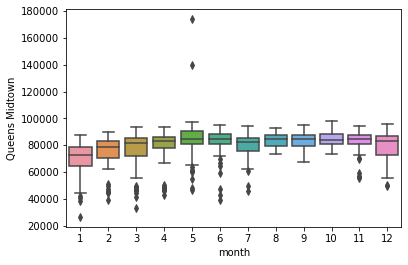

In [97]:
sns.boxplot(x='month', y='Queens Midtown', data=_df['2018':'2019'])

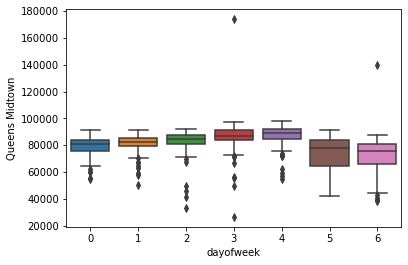

In [98]:
sns.boxplot(x='dayofweek', y='Queens Midtown', data=_df['2018':'2019'])

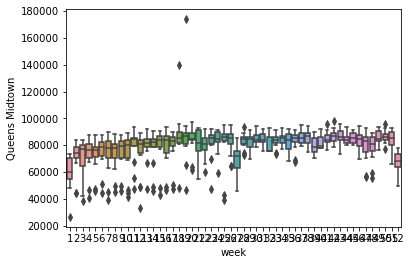

In [99]:
sns.boxplot(x='week', y='Queens Midtown', data=_df['2018':'2019'])

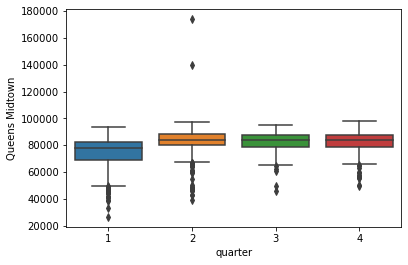

In [100]:
sns.boxplot(x='quarter', y='Queens Midtown', data=_df['2018':'2019'])

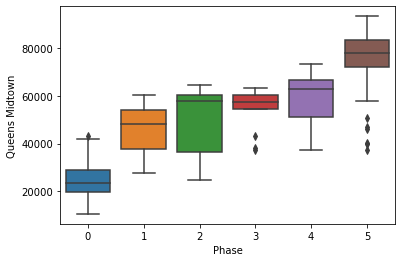

In [101]:
sns.boxplot(x='Phase', y='Queens Midtown', data=_df['2020'])

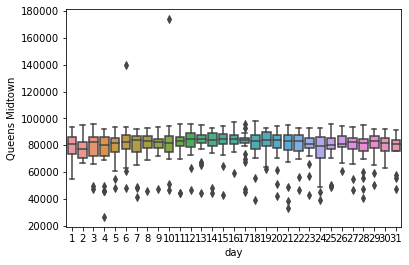

In [102]:
sns.boxplot(x='day', y='Queens Midtown', data=_df['2018':'2019'])

In [104]:
_df['total'] = _df['Brooklyn Battery'] + _df['Cross Bay'] + _df['Henry Hudson'] + _df['Marine Parkway'] + _df['Queens Midtown'] + \
                _df['Throgs Neck'] + _df['Triboro Bronx'] + _df['Triboro Manhattan'] + _df['Verrazano'] + _df['Whitestone']  

In [105]:
_df

plaza_id,Brooklyn Battery,Cross Bay,Henry Hudson,Marine Parkway,Queens Midtown,Throgs Neck,Triboro Bronx,Triboro Manhattan,Verrazano,Whitestone,month,dayofweek,year,week,day,quarter,Phase,total
datetime,,,,,,,,,,,,,,,,,,
2018-01-01,29163,13705,46540,12118,54907,98346,110224,30551,81923,109286,1,0,2018,1,1,1,5,586763
2018-01-02,47160,21875,60610,19887,67000,106264,129574,35356,95649,117211,1,1,2018,1,2,1,5,700586
2018-01-03,54005,24607,67983,22067,71725,115952,136213,38937,103506,123974,1,2,2018,1,3,1,5,758969
2018-01-04,20484,8303,14502,6167,26625,28406,50867,13270,37820,38114,1,3,2018,1,4,1,5,244558
2018-01-05,38007,16839,49850,13929,55153,80477,105945,29308,74375,91229,1,4,2018,1,5,1,5,555112
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-09-08,55105,24644,60591,25524,66662,106502,130435,34153,100146,121270,9,1,2020,37,8,3,4,725032
2020-09-09,56553,22692,62026,22821,67238,104707,128069,35541,99250,118513,9,2,2020,37,9,3,4,717410
2020-09-10,55672,20742,60627,20495,65909,100158,125216,34303,97574,114546,9,3,2020,37,10,3,4,695242


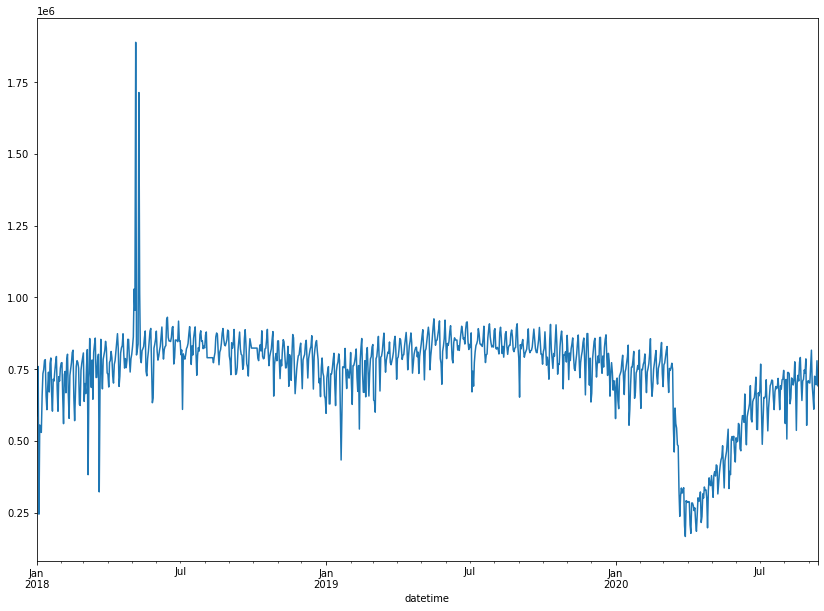

In [107]:
_df['total'].plot(figsize=(14,10))

In [108]:
_df.columns

Index(['Brooklyn Battery', 'Cross Bay', 'Henry Hudson', 'Marine Parkway',
       'Queens Midtown', 'Throgs Neck', 'Triboro Bronx', 'Triboro Manhattan',
       'Verrazano', 'Whitestone', 'month', 'dayofweek', 'year', 'week', 'day',
       'quarter', 'Phase', 'total'],
      dtype='object', name='plaza_id')

In [109]:
_bridges = ['Brooklyn Battery', 'Cross Bay', 'Henry Hudson', 'Marine Parkway',
       'Queens Midtown', 'Throgs Neck', 'Triboro Bronx', 'Triboro Manhattan',
       'Verrazano', 'Whitestone']

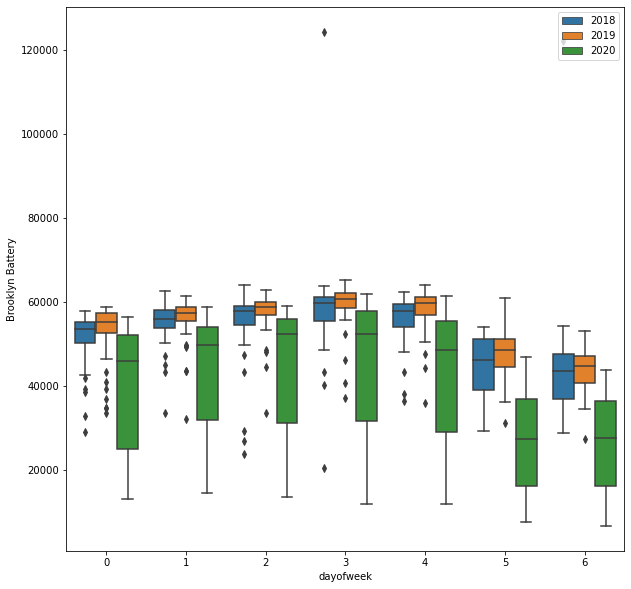

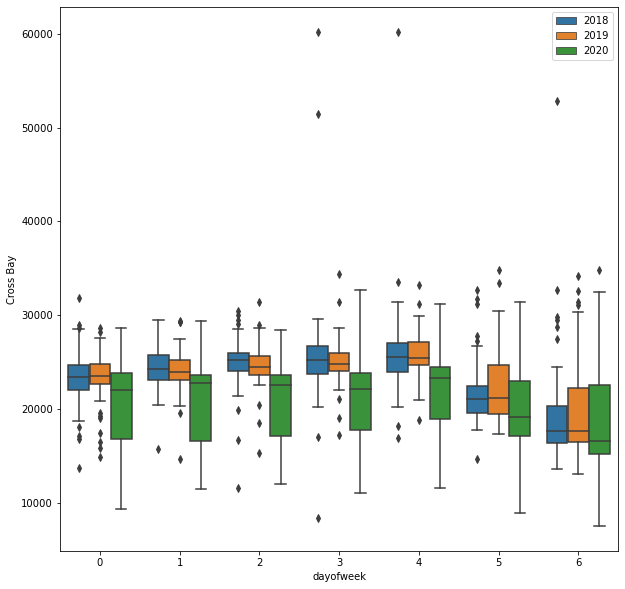

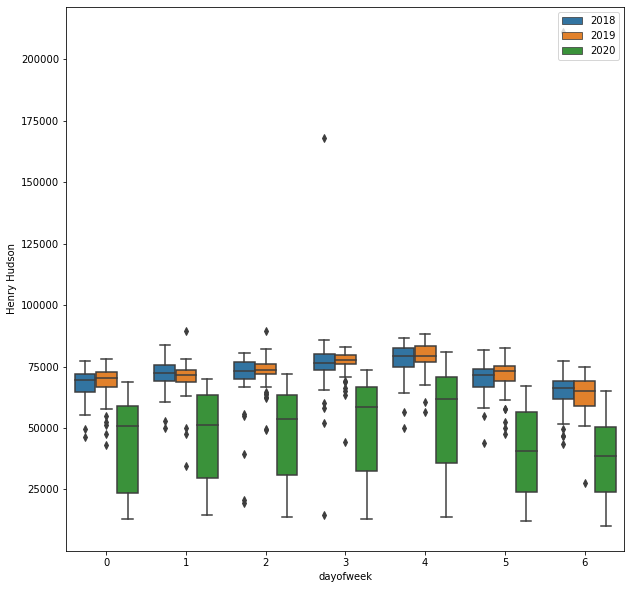

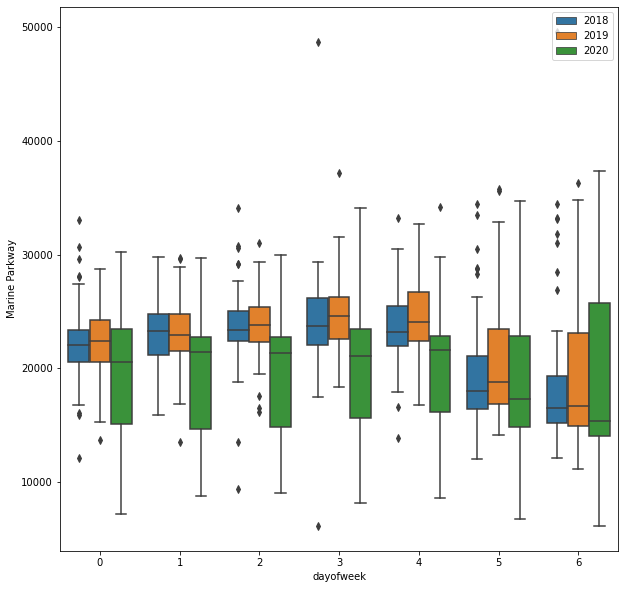

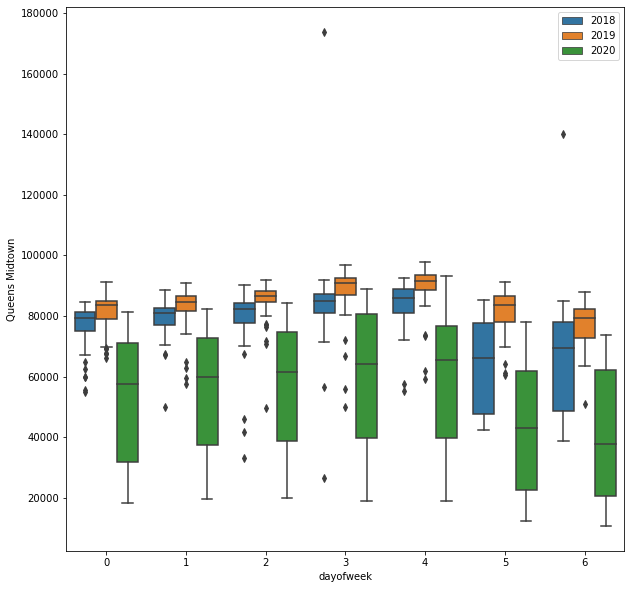

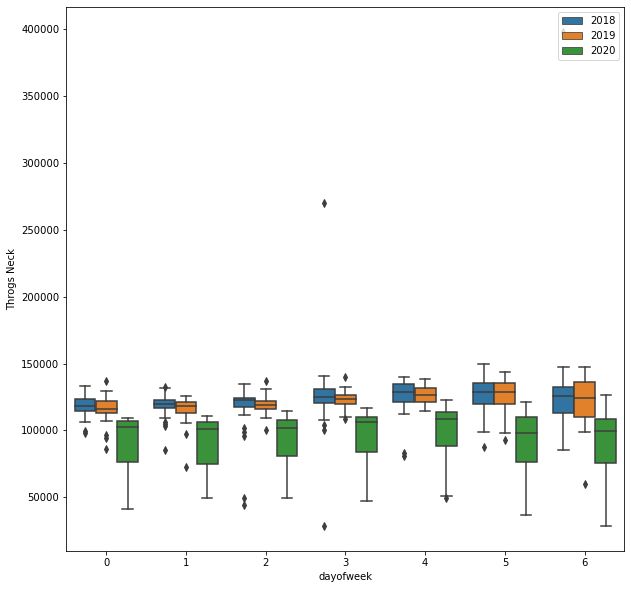

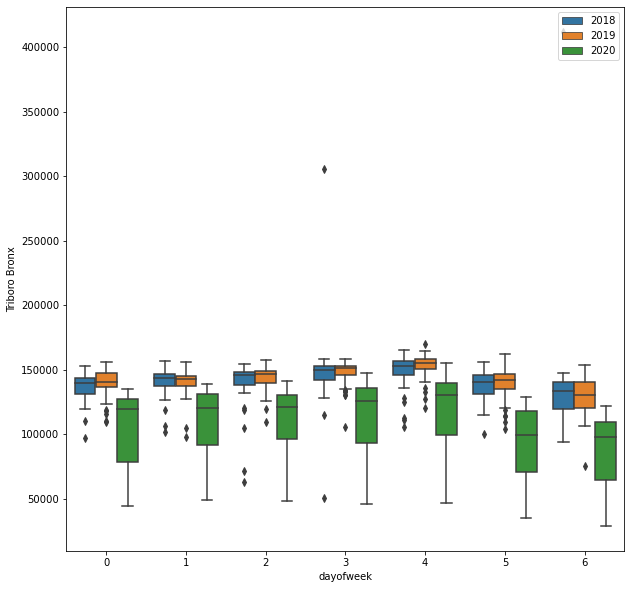

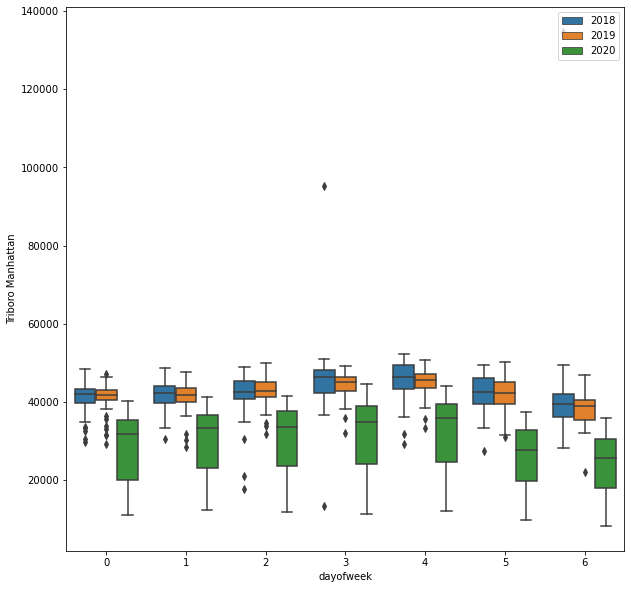

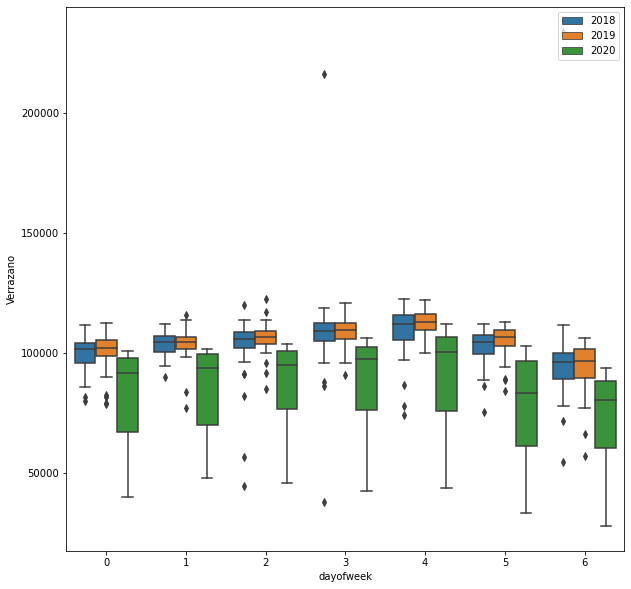

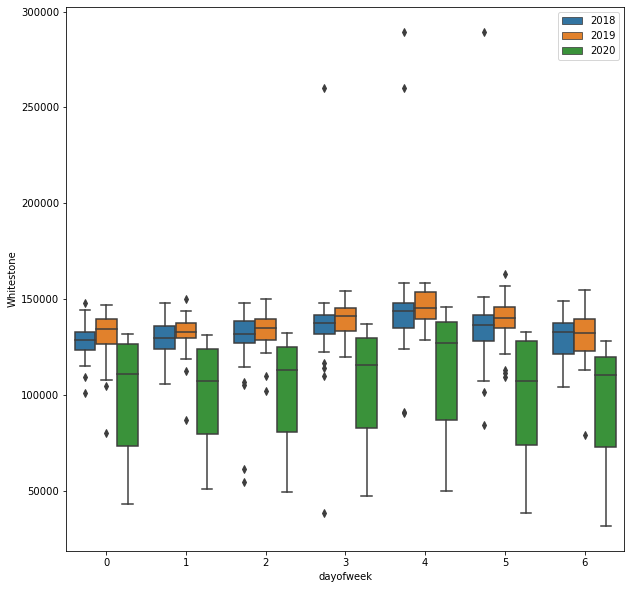

In [118]:
for i in _bridges:
    plt.figure(figsize=(10,10))
    sns.boxplot(x='dayofweek', y=i, data=_df, hue='year')
    plt.legend(loc='upper right')
    plt.show()

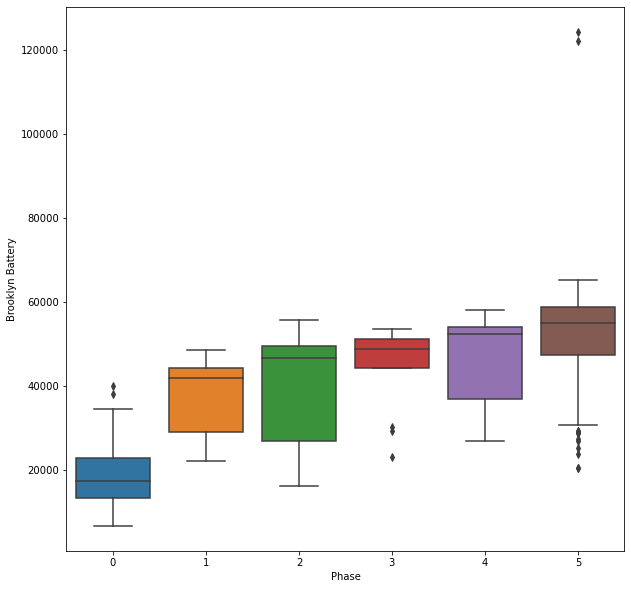

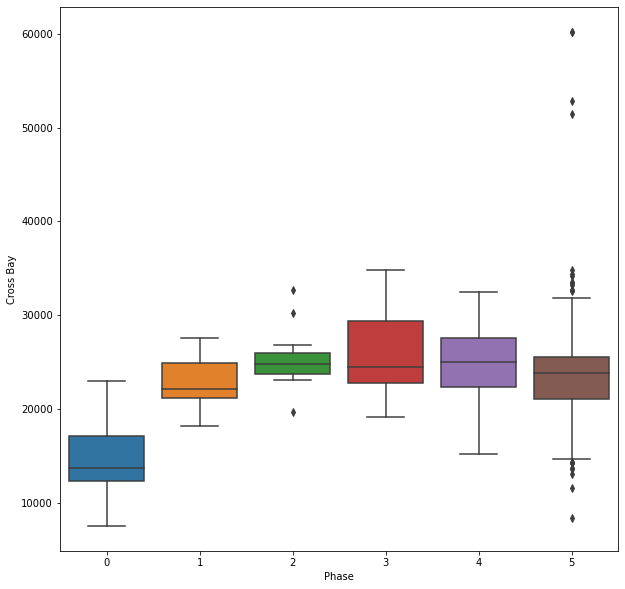

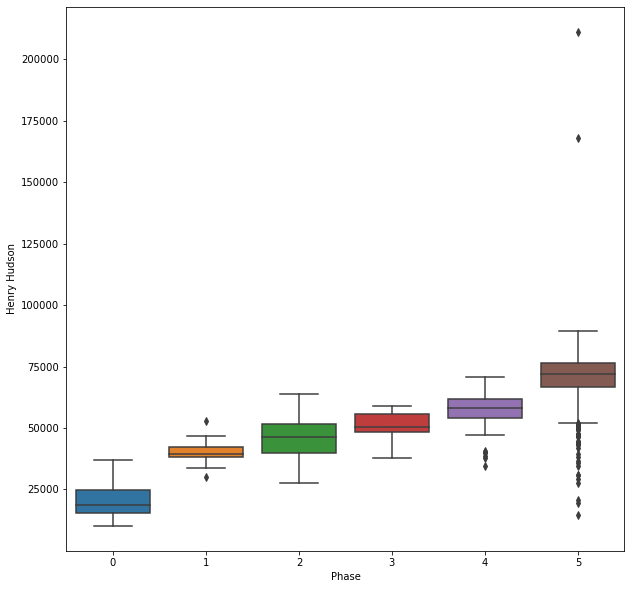

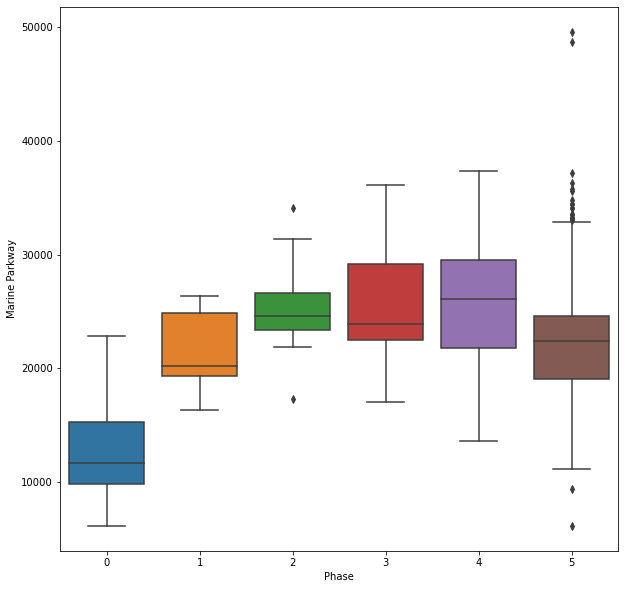

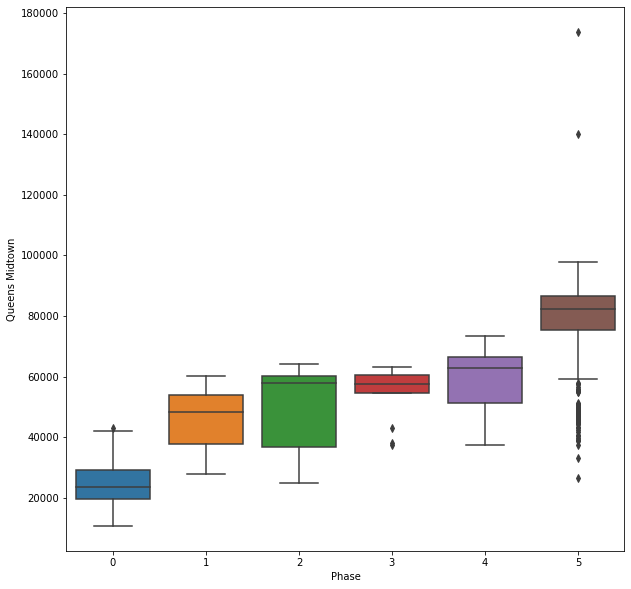

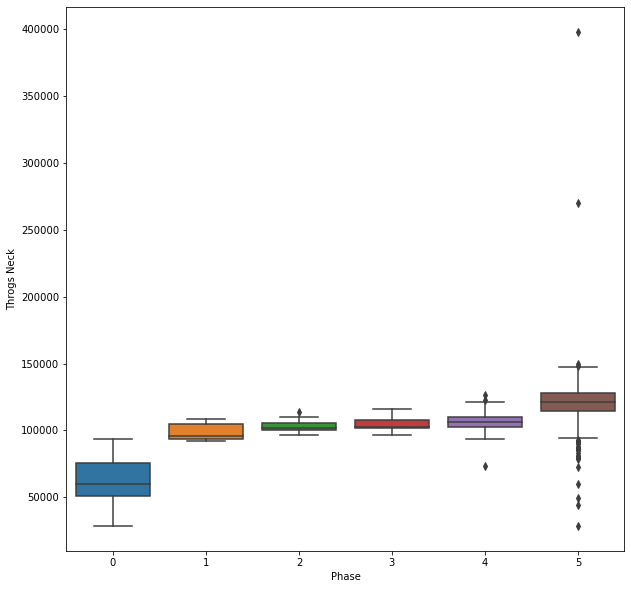

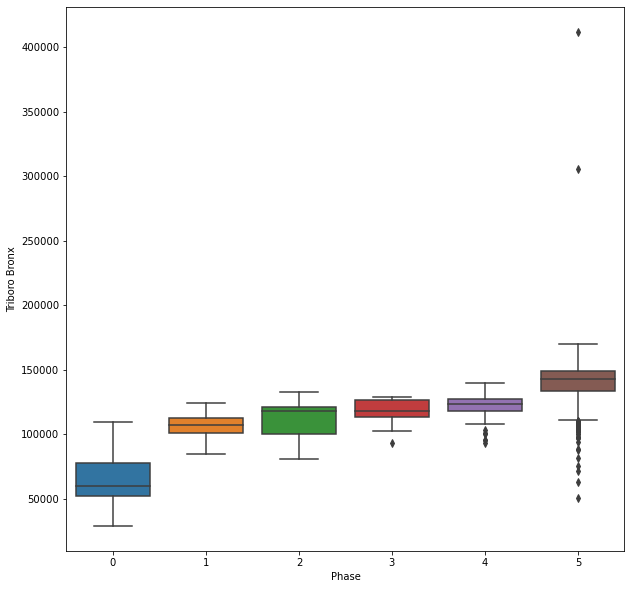

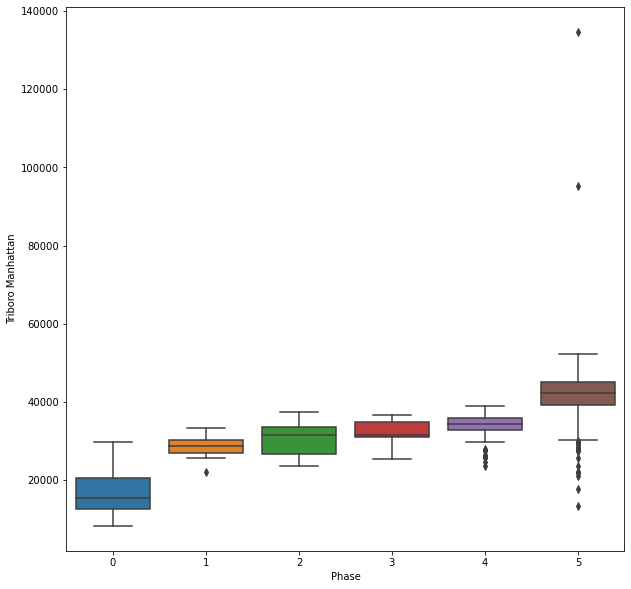

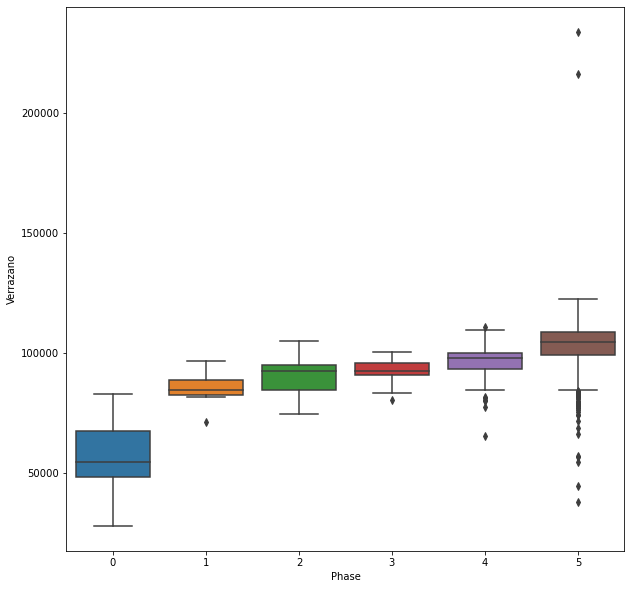

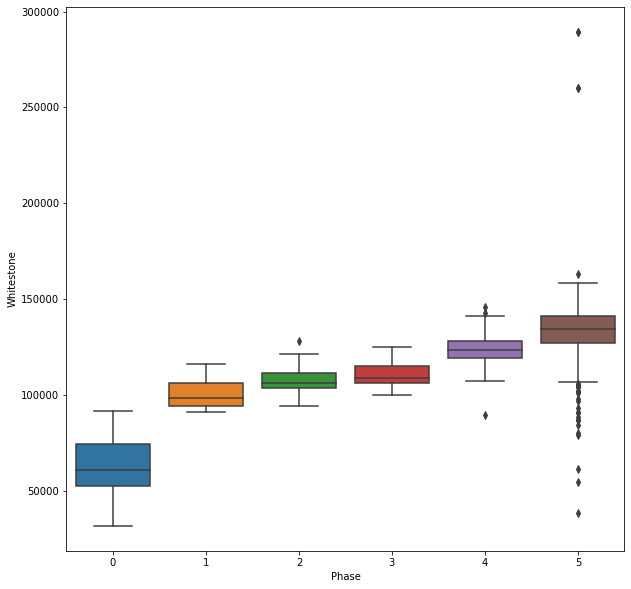

In [121]:
for i in _bridges:
    plt.figure(figsize=(10,10))
    sns.boxplot(x='Phase', y=i, data=_df)
#     plt.legend(loc='upper right')
    plt.show()